In [7]:
print('Module 4_2: GNN prediction model training')

Module 4_2: GNN prediction model training


In [8]:
import numpy as np
import pandas as pd
import argparse
import pickle
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from gnn_model import GNN 

# Parse input

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch implementation of pre-training of graph neural networks')
parser.add_argument('--device', type=int, default=0, required=False,
                        help='which gpu to use if any (default: 0)')
parser.add_argument('--batch_size', type=int, default=512, required=False,
                        help='input batch size for training (default: 512)')
parser.add_argument('--epochs', type=int, default=200, required=False,
                        help='number of epochs to train (default: 200)')
parser.add_argument('--lr', type=float, default=0.001, required=False,
                        help='learning rate (default: 0.001)')
parser.add_argument('--decay', type=float, default=1e-4, required=False,
                        help='weight decay (default: 1e-4)')
parser.add_argument('--num_layer', type=int, default=5, required=False,
                        help='number of GNN message passing layers (default: 5)')
parser.add_argument('--emb_dim', type=int, default=512, required=False,
                        help='embedding dimensions (default: 512)')
parser.add_argument('--dropout_ratio', type=float, default=0.2, required=False,
                        help='dropout ratio (default: 0.2)')
parser.add_argument('--JK', type=str, default='concat', required=False,
                        help='how the node features across layers are combined. concat, sum, max or last')
parser.add_argument('--gnn_type', type=str, default='gcn', required=False,
                        help='gnn type. gcn, gin, gat, graphsage')
parser.add_argument('--num_workers', type=int, default=8, required=False, 
                        help='number of workers for dataset loading')
parser.add_argument('-u', required=True, help='The uniprot id of your target')                        

args = parser.parse_args()

# Make functions

In [ ]:
def load_data(batch_size=512, num_workers=8):

    with open(args.u+'_gnn_train_data.pkl', 'rb') as f:
        train_dataset = pickle.load(f)
    with open(args.u+'_gnn_val_data.pkl', 'rb') as f:
        val_dataset = pickle.load(f)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False, pin_memory=True)

    return train_loader, val_loader

In [11]:
class Trainer:
    def __init__(self, model, train_loader, val_loader):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.decay)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='max', factor=0.5, patience=10, min_lr=1e-6)
        self.criterion = self.get_loss_criterion(train_loader.dataset)
        self.train_losses = []
        self.train_metrics = []
        self.val_metrics = []

    def get_loss_criterion(self, dataset):
        pos_count = sum(1 for data in dataset if data.y.item() == 1)
        pos_ratio = pos_count / len(dataset)
        class_weights = torch.tensor([1.0, (1 - pos_ratio) / pos_ratio]).to(device)
        return torch.nn.CrossEntropyLoss(weight=class_weights)

    def train_epoch(self):
        self.model.train()
        total_loss = 0
        total_samples = 0
        for batch in tqdm(self.train_loader, desc="Training"):
            batch = batch.to(device)
            self.optimizer.zero_grad()
            out = self.model(batch)
            loss = self.criterion(out, batch.y.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 2.0)
            self.optimizer.step()
            total_loss += loss.item() * batch.num_graphs
            total_samples += batch.num_graphs
        return total_loss / total_samples

    def evaluate(self, loader, desc="Evaluating"):
        self.model.eval()
        y_true, y_pred, y_score = [], [], []
        with torch.no_grad():
            for batch in tqdm(loader, desc=desc):
                batch = batch.to(device)
                out = self.model(batch)
                pred = out.argmax(dim=1)
                y_true.extend(batch.y.cpu().numpy().flatten())
                y_pred.extend(pred.cpu().numpy())
                y_score.extend(F.softmax(out, dim=1)[:, 1].cpu().numpy())
        metrics = self.compute_metrics(y_true, y_pred, y_score)
        return metrics

    def compute_metrics(self, y_true, y_pred, y_score):
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        gmean = geometric_mean_score(y_true, y_pred)
        iba_gmean = make_index_balanced_accuracy(alpha=0.1, squared=True)(geometric_mean_score)
        iba = iba_gmean(y_true, y_pred)
        return {
            "accuracy": sum(1 for y_p, y_t in zip(y_pred, y_true) if y_p == y_t) / len(y_true),
            "auc_roc": roc_auc_score(y_true, y_score),
            "f1": f1_score(y_true, y_pred),
            "precision": precision_score(y_true, y_pred),
            "recall": recall_score(y_true, y_pred),
            "specificity": specificity,
            "gmean": gmean,
            "iba": iba
        }
    
    def save_model(self):
        model_path = f'gnn_model.pth'  
        torch.save(self.model, model_path)
        print(f'Model saved to {model_path}')

    def run(self):
        for epoch in range(1, args.epochs + 1):
            epoch_loss = self.train_epoch()
            train_metric = self.evaluate(self.train_loader, desc="Evaluating Train")
            val_metric = self.evaluate(self.val_loader, desc="Evaluating Val")
            self.scheduler.step(val_metric["auc_roc"])
            self.train_losses.append(epoch_loss)
            self.train_metrics.append(train_metric)
            self.val_metrics.append(val_metric)
            print(f'Epoch: {epoch:03d}, '
                  f'Train Loss: {epoch_loss:.4f}, '
                  f'Train Acc: {train_metric["accuracy"]:.4f}, '
                  f'Val Acc: {val_metric["accuracy"]:.4f}, '
                  f'Val AUC: {val_metric["auc_roc"]:.4f}, '
                  f'Val Precision: {val_metric["precision"]:.4f}, '
                  f'Val Recall: {val_metric["recall"]:.4f}, '
                  f'Val Specificity: {val_metric["specificity"]:.4f}, '
                  f'Val F1: {val_metric["f1"]:.4f}, '
                  f'Val G-Mean: {val_metric["gmean"]:.4f}, '
                  f'Val IBA: {val_metric["iba"]:.4f}')
            
            if epoch == args.epochs:
                self.save_model()    

In [12]:
def plot_training_dashboard(trainer):
    train_metrics = trainer.train_metrics
    val_metrics = trainer.val_metrics
    train_losses = trainer.train_losses

    train_accuracies = [m["accuracy"] for m in train_metrics]
    val_accuracies = [m["accuracy"] for m in val_metrics]
    train_aucs = [m["auc_roc"] for m in train_metrics]
    val_aucs = [m["auc_roc"] for m in val_metrics]
    train_precisions = [m["precision"] for m in train_metrics]
    val_precisions = [m["precision"] for m in val_metrics]
    train_recalls = [m["recall"] for m in train_metrics]
    val_recalls = [m["recall"] for m in val_metrics]
    train_specificities = [m["specificity"] for m in train_metrics]
    val_specificities = [m["specificity"] for m in val_metrics]
    train_gmeans = [m["gmean"] for m in train_metrics]
    val_gmeans = [m["gmean"] for m in val_metrics]
    train_ibas = [m["iba"] for m in train_metrics]
    val_ibas = [m["iba"] for m in val_metrics]

    plt.figure(figsize=(20, 15), facecolor='white')

    TRAIN_COLOR = '#2c7bb6' 
    VAL_COLOR = '#d7191c'   
    GM_COLOR = '#008837'     
    IBA_COLOR = '#7b3294'   
    PRECISION_COLOR = '#2c7bb6'  
    RECALL_COLOR = '#fdae61'     
    SPECIFICITY_COLOR = '#5e3c99' 

    line_style = {
        'train': {'linewidth': 2, 'alpha': 0.9, 'linestyle': '-'},
        'val': {'linewidth': 2, 'alpha': 0.9, 'linestyle': '--'}
    }
    fill_style = {'alpha': 0.2, 'interpolate': True}

    plt.rcParams.update({
        'font.size': 11,
        'axes.titlesize': 13,
        'axes.labelsize': 12,
        'legend.fontsize': 10
    })

    # 1. Training Loss
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(train_losses, label='Training', color=TRAIN_COLOR, **line_style['train'])
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss', pad=12)
    ax1.grid(True, linestyle=':', alpha=0.7)
    ax1.legend(framealpha=0.9)

    # 2. Accuracy
    ax2 = plt.subplot(3, 3, 2)
    ax2.plot(train_accuracies, label='Train', color=TRAIN_COLOR, **line_style['train'])
    ax2.plot(val_accuracies, label='Validation', color=VAL_COLOR, **line_style['val'])
    ax2.fill_between(range(len(train_accuracies)), 
                    train_accuracies, val_accuracies, 
                    where=(np.array(train_accuracies) > np.array(val_accuracies)),
                    color='green', **fill_style)
    ax2.fill_between(range(len(train_accuracies)), 
                    train_accuracies, val_accuracies,
                    where=(np.array(train_accuracies) <= np.array(val_accuracies)),
                    color='red', **fill_style)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Model Accuracy', pad=12)
    ax2.grid(True, linestyle=':', alpha=0.7)
    ax2.legend(framealpha=0.9)

    # 3. AUC-ROC 
    window_size = 3
    smoothed_train_auc = np.convolve(train_aucs, np.ones(window_size)/window_size, mode='valid')
    smoothed_val_auc = np.convolve(val_aucs, np.ones(window_size)/window_size, mode='valid')

    ax3 = plt.subplot(3, 3, 3)
    ax3.plot(smoothed_train_auc, label=f'Train (smoothed {window_size}ep)', 
             color=TRAIN_COLOR, **line_style['train'])
    ax3.plot(smoothed_val_auc, label=f'Validation (smoothed {window_size}ep)',
             color=VAL_COLOR, **line_style['val'])
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC-ROC')
    ax3.set_title('ROC Area Under Curve', pad=12)
    ax3.grid(True, linestyle=':', alpha=0.7)
    ax3.legend(framealpha=0.9)

    # 4. Precision-Recall-Specificity
    ax4 = plt.subplot(3, 3, (4,6))
    ax4.plot(train_precisions, label='Train Precision', color=PRECISION_COLOR, **line_style['train'])
    ax4.plot(val_precisions, label='Val Precision', color=PRECISION_COLOR, **line_style['val'])
    ax4.plot(train_recalls, label='Train Recall', color=RECALL_COLOR, **line_style['train'])
    ax4.plot(val_recalls, label='Val Recall', color=RECALL_COLOR, **line_style['val'])
    ax4.plot(train_specificities, label='Train Specificity', color=SPECIFICITY_COLOR, **line_style['train'])
    ax4.plot(val_specificities, label='Val Specificity', color=SPECIFICITY_COLOR, **line_style['val'])
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Score')
    ax4.set_title('Precision-Recall-Specificity Tradeoff', pad=12)
    ax4.grid(True, linestyle=':', alpha=0.7)
    ax4.legend(ncol=2, framealpha=0.9)

    # 5. G-Mean & IBA
    ax5 = plt.subplot(3, 3, (7,9))
    ax5.plot(train_gmeans, label='Train G-Mean', color=GM_COLOR, **line_style['train'])
    ax5.plot(val_gmeans, label='Val G-Mean', color=GM_COLOR, **line_style['val'])
    ax5.plot(train_ibas, label='Train IBA', color=IBA_COLOR, **line_style['train'])
    ax5.plot(val_ibas, label='Val IBA', color=IBA_COLOR, **line_style['val'])
    ax5.set_xlabel('Epoch')
    ax5.set_ylabel('Score')
    ax5.set_title('Imbalance-aware Metrics', pad=12)
    ax5.grid(True, linestyle=':', alpha=0.7)
    ax5.legend(framealpha=0.9)

    plt.tight_layout(pad=3.0, w_pad=2.0, h_pad=2.0)
    plt.suptitle('Model Training Metrics Dashboard', y=1.02, fontsize=16, fontweight='bold')
    plt.savefig('training_metrics_dashboard.png', dpi=300, bbox_inches='tight')
    plt.show()

Evaluating Train: 100%|██████████| 9/9 [00:05<00:00,  1.56it/s]
/home/bianlab/software/anaconda3/2024.06/envs/TAME_VS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]
/home/bianlab/software/anaconda3/2024.06/envs/TAME_VS/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch: 001, Train Loss: 0.7898, Train Acc: 0.1969, Val Acc: 0.1968, Val AUC: 0.6436, Val Precision: 0.0000, Val Recall: 0.0000, Val Specificity: 1.0000, Val F1: 0.0000, Val G-Mean: 0.0000, Val IBA: 0.0000


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 002, Train Loss: 0.6447, Train Acc: 0.2116, Val Acc: 0.2109, Val AUC: 0.7017, Val Precision: 0.9000, Val Recall: 0.0197, Val Specificity: 0.9911, Val F1: 0.0385, Val G-Mean: 0.1397, Val IBA: 0.0195


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 003, Train Loss: 0.6036, Train Acc: 0.2185, Val Acc: 0.2206, Val AUC: 0.7174, Val Precision: 0.9091, Val Recall: 0.0328, Val Specificity: 0.9866, Val F1: 0.0634, Val G-Mean: 0.1800, Val IBA: 0.0324


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 004, Train Loss: 0.5873, Train Acc: 0.2934, Val Acc: 0.2803, Val AUC: 0.7168, Val Precision: 0.9279, Val Recall: 0.1127, Val Specificity: 0.9643, Val F1: 0.2010, Val G-Mean: 0.3296, Val IBA: 0.1087


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 005, Train Loss: 0.5792, Train Acc: 0.4145, Val Acc: 0.3972, Val AUC: 0.7543, Val Precision: 0.9351, Val Recall: 0.2681, Val Specificity: 0.9241, Val F1: 0.4167, Val G-Mean: 0.4977, Val IBA: 0.2477


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 006, Train Loss: 0.5800, Train Acc: 0.7905, Val Acc: 0.7680, Val AUC: 0.7451, Val Precision: 0.8744, Val Recall: 0.8304, Val Specificity: 0.5134, Val F1: 0.8519, Val G-Mean: 0.6529, Val IBA: 0.4263


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 007, Train Loss: 0.5782, Train Acc: 0.7503, Val Acc: 0.7364, Val AUC: 0.7625, Val Precision: 0.9018, Val Recall: 0.7538, Val Specificity: 0.6652, Val F1: 0.8212, Val G-Mean: 0.7081, Val IBA: 0.5014


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 008, Train Loss: 0.5578, Train Acc: 0.6679, Val Acc: 0.6520, Val AUC: 0.7730, Val Precision: 0.9111, Val Recall: 0.6280, Val Specificity: 0.7500, Val F1: 0.7435, Val G-Mean: 0.6863, Val IBA: 0.4710


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 009, Train Loss: 0.5475, Train Acc: 0.7941, Val Acc: 0.7715, Val AUC: 0.7797, Val Precision: 0.8902, Val Recall: 0.8162, Val Specificity: 0.5893, Val F1: 0.8516, Val G-Mean: 0.6935, Val IBA: 0.4810


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 010, Train Loss: 0.5370, Train Acc: 0.8424, Val Acc: 0.8278, Val AUC: 0.7717, Val Precision: 0.8724, Val Recall: 0.9201, Val Specificity: 0.4509, Val F1: 0.8956, Val G-Mean: 0.6441, Val IBA: 0.4149


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 011, Train Loss: 0.5310, Train Acc: 0.4312, Val Acc: 0.4174, Val AUC: 0.7778, Val Precision: 0.9498, Val Recall: 0.2899, Val Specificity: 0.9375, Val F1: 0.4443, Val G-Mean: 0.5214, Val IBA: 0.2718


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 012, Train Loss: 0.5245, Train Acc: 0.7813, Val Acc: 0.7452, Val AUC: 0.7853, Val Precision: 0.8990, Val Recall: 0.7691, Val Specificity: 0.6473, Val F1: 0.8290, Val G-Mean: 0.7056, Val IBA: 0.4979


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 013, Train Loss: 0.5193, Train Acc: 0.8143, Val Acc: 0.7917, Val AUC: 0.7998, Val Precision: 0.8869, Val Recall: 0.8490, Val Specificity: 0.5580, Val F1: 0.8675, Val G-Mean: 0.6883, Val IBA: 0.4738


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 014, Train Loss: 0.5173, Train Acc: 0.8068, Val Acc: 0.7803, Val AUC: 0.7902, Val Precision: 0.8924, Val Recall: 0.8260, Val Specificity: 0.5938, Val F1: 0.8580, Val G-Mean: 0.7003, Val IBA: 0.4905


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 015, Train Loss: 0.5092, Train Acc: 0.6204, Val Acc: 0.6019, Val AUC: 0.8068, Val Precision: 0.9374, Val Recall: 0.5405, Val Specificity: 0.8527, Val F1: 0.6856, Val G-Mean: 0.6789, Val IBA: 0.4609


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 016, Train Loss: 0.5090, Train Acc: 0.7925, Val Acc: 0.7627, Val AUC: 0.8034, Val Precision: 0.9076, Val Recall: 0.7845, Val Specificity: 0.6741, Val F1: 0.8415, Val G-Mean: 0.7272, Val IBA: 0.5288


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 017, Train Loss: 0.5040, Train Acc: 0.7796, Val Acc: 0.7557, Val AUC: 0.8073, Val Precision: 0.9025, Val Recall: 0.7801, Val Specificity: 0.6562, Val F1: 0.8369, Val G-Mean: 0.7155, Val IBA: 0.5119


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 018, Train Loss: 0.5095, Train Acc: 0.7589, Val Acc: 0.7469, Val AUC: 0.8176, Val Precision: 0.9196, Val Recall: 0.7505, Val Specificity: 0.7321, Val F1: 0.8265, Val G-Mean: 0.7413, Val IBA: 0.5495


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 019, Train Loss: 0.4971, Train Acc: 0.7424, Val Acc: 0.7179, Val AUC: 0.8095, Val Precision: 0.9266, Val Recall: 0.7046, Val Specificity: 0.7723, Val F1: 0.8005, Val G-Mean: 0.7377, Val IBA: 0.5442


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 020, Train Loss: 0.5022, Train Acc: 0.6257, Val Acc: 0.6019, Val AUC: 0.8256, Val Precision: 0.9511, Val Recall: 0.5317, Val Specificity: 0.8884, Val F1: 0.6821, Val G-Mean: 0.6873, Val IBA: 0.4724


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 021, Train Loss: 0.4919, Train Acc: 0.8182, Val Acc: 0.8032, Val AUC: 0.8239, Val Precision: 0.9040, Val Recall: 0.8446, Val Specificity: 0.6339, Val F1: 0.8733, Val G-Mean: 0.7317, Val IBA: 0.5354


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 022, Train Loss: 0.4843, Train Acc: 0.8354, Val Acc: 0.8190, Val AUC: 0.8213, Val Precision: 0.8899, Val Recall: 0.8840, Val Specificity: 0.5536, Val F1: 0.8869, Val G-Mean: 0.6996, Val IBA: 0.4894


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 023, Train Loss: 0.4951, Train Acc: 0.8330, Val Acc: 0.8181, Val AUC: 0.8200, Val Precision: 0.8855, Val Recall: 0.8884, Val Specificity: 0.5312, Val F1: 0.8869, Val G-Mean: 0.6870, Val IBA: 0.4720


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 024, Train Loss: 0.4931, Train Acc: 0.8132, Val Acc: 0.7900, Val AUC: 0.8420, Val Precision: 0.9052, Val Recall: 0.8249, Val Specificity: 0.6473, Val F1: 0.8632, Val G-Mean: 0.7308, Val IBA: 0.5340


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 025, Train Loss: 0.4955, Train Acc: 0.8420, Val Acc: 0.8278, Val AUC: 0.8174, Val Precision: 0.8763, Val Recall: 0.9147, Val Specificity: 0.4732, Val F1: 0.8951, Val G-Mean: 0.6579, Val IBA: 0.4328


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 026, Train Loss: 0.4896, Train Acc: 0.7382, Val Acc: 0.7250, Val AUC: 0.8482, Val Precision: 0.9311, Val Recall: 0.7101, Val Specificity: 0.7857, Val F1: 0.8057, Val G-Mean: 0.7469, Val IBA: 0.5579


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 027, Train Loss: 0.4920, Train Acc: 0.8387, Val Acc: 0.8172, Val AUC: 0.8295, Val Precision: 0.8993, Val Recall: 0.8698, Val Specificity: 0.6027, Val F1: 0.8843, Val G-Mean: 0.7240, Val IBA: 0.5242


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 028, Train Loss: 0.4715, Train Acc: 0.8516, Val Acc: 0.8383, Val AUC: 0.8247, Val Precision: 0.8942, Val Recall: 0.9059, Val Specificity: 0.5625, Val F1: 0.9000, Val G-Mean: 0.7138, Val IBA: 0.5096


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 029, Train Loss: 0.4694, Train Acc: 0.7785, Val Acc: 0.7557, Val AUC: 0.8347, Val Precision: 0.9206, Val Recall: 0.7615, Val Specificity: 0.7321, Val F1: 0.8335, Val G-Mean: 0.7467, Val IBA: 0.5575


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 030, Train Loss: 0.4623, Train Acc: 0.8404, Val Acc: 0.8216, Val AUC: 0.8480, Val Precision: 0.8981, Val Recall: 0.8775, Val Specificity: 0.5938, Val F1: 0.8877, Val G-Mean: 0.7218, Val IBA: 0.5210


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 031, Train Loss: 0.4608, Train Acc: 0.7497, Val Acc: 0.7223, Val AUC: 0.8371, Val Precision: 0.9333, Val Recall: 0.7046, Val Specificity: 0.7946, Val F1: 0.8030, Val G-Mean: 0.7483, Val IBA: 0.5599


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 032, Train Loss: 0.4529, Train Acc: 0.8589, Val Acc: 0.8427, Val AUC: 0.7987, Val Precision: 0.8599, Val Recall: 0.9606, Val Specificity: 0.3616, Val F1: 0.9075, Val G-Mean: 0.5894, Val IBA: 0.3474


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 033, Train Loss: 0.4521, Train Acc: 0.8609, Val Acc: 0.8383, Val AUC: 0.8569, Val Precision: 0.9020, Val Recall: 0.8961, Val Specificity: 0.6027, Val F1: 0.8990, Val G-Mean: 0.7349, Val IBA: 0.5400


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 034, Train Loss: 0.4408, Train Acc: 0.7697, Val Acc: 0.7452, Val AUC: 0.8672, Val Precision: 0.9419, Val Recall: 0.7276, Val Specificity: 0.8170, Val F1: 0.8210, Val G-Mean: 0.7710, Val IBA: 0.5944


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 035, Train Loss: 0.4621, Train Acc: 0.8242, Val Acc: 0.8014, Val AUC: 0.8509, Val Precision: 0.9038, Val Recall: 0.8425, Val Specificity: 0.6339, Val F1: 0.8720, Val G-Mean: 0.7308, Val IBA: 0.5341


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 036, Train Loss: 0.4546, Train Acc: 0.6389, Val Acc: 0.6239, Val AUC: 0.8726, Val Precision: 0.9746, Val Recall: 0.5460, Val Specificity: 0.9420, Val F1: 0.6999, Val G-Mean: 0.7171, Val IBA: 0.5143


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 037, Train Loss: 0.4475, Train Acc: 0.7844, Val Acc: 0.7671, Val AUC: 0.8706, Val Precision: 0.9403, Val Recall: 0.7582, Val Specificity: 0.8036, Val F1: 0.8395, Val G-Mean: 0.7806, Val IBA: 0.6093


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 038, Train Loss: 0.4178, Train Acc: 0.8369, Val Acc: 0.8128, Val AUC: 0.8681, Val Precision: 0.9158, Val Recall: 0.8446, Val Specificity: 0.6830, Val F1: 0.8788, Val G-Mean: 0.7596, Val IBA: 0.5769


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 039, Train Loss: 0.4226, Train Acc: 0.8088, Val Acc: 0.7777, Val AUC: 0.8661, Val Precision: 0.9265, Val Recall: 0.7856, Val Specificity: 0.7455, Val F1: 0.8502, Val G-Mean: 0.7653, Val IBA: 0.5857


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 040, Train Loss: 0.4135, Train Acc: 0.6884, Val Acc: 0.6740, Val AUC: 0.8747, Val Precision: 0.9625, Val Recall: 0.6182, Val Specificity: 0.9018, Val F1: 0.7528, Val G-Mean: 0.7466, Val IBA: 0.5574


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 041, Train Loss: 0.4089, Train Acc: 0.8292, Val Acc: 0.8128, Val AUC: 0.8830, Val Precision: 0.9290, Val Recall: 0.8304, Val Specificity: 0.7411, Val F1: 0.8769, Val G-Mean: 0.7845, Val IBA: 0.6154


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 042, Train Loss: 0.4025, Train Acc: 0.7824, Val Acc: 0.7592, Val AUC: 0.8858, Val Precision: 0.9432, Val Recall: 0.7451, Val Specificity: 0.8170, Val F1: 0.8325, Val G-Mean: 0.7802, Val IBA: 0.6087


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 043, Train Loss: 0.4195, Train Acc: 0.8651, Val Acc: 0.8462, Val AUC: 0.8861, Val Precision: 0.9213, Val Recall: 0.8840, Val Specificity: 0.6920, Val F1: 0.9023, Val G-Mean: 0.7821, Val IBA: 0.6117


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 044, Train Loss: 0.4185, Train Acc: 0.8244, Val Acc: 0.7961, Val AUC: 0.8863, Val Precision: 0.9327, Val Recall: 0.8042, Val Specificity: 0.7634, Val F1: 0.8637, Val G-Mean: 0.7835, Val IBA: 0.6139


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 045, Train Loss: 0.4287, Train Acc: 0.7908, Val Acc: 0.7601, Val AUC: 0.8752, Val Precision: 0.9396, Val Recall: 0.7495, Val Specificity: 0.8036, Val F1: 0.8338, Val G-Mean: 0.7760, Val IBA: 0.6022


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 046, Train Loss: 0.4014, Train Acc: 0.8881, Val Acc: 0.8708, Val AUC: 0.8912, Val Precision: 0.8991, Val Recall: 0.9453, Val Specificity: 0.5670, Val F1: 0.9216, Val G-Mean: 0.7321, Val IBA: 0.5359


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 047, Train Loss: 0.3924, Train Acc: 0.8567, Val Acc: 0.8269, Val AUC: 0.8656, Val Precision: 0.8997, Val Recall: 0.8829, Val Specificity: 0.5982, Val F1: 0.8912, Val G-Mean: 0.7268, Val IBA: 0.5282


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 048, Train Loss: 0.3957, Train Acc: 0.8576, Val Acc: 0.8260, Val AUC: 0.8804, Val Precision: 0.9115, Val Recall: 0.8676, Val Specificity: 0.6562, Val F1: 0.8890, Val G-Mean: 0.7546, Val IBA: 0.5694


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 049, Train Loss: 0.3813, Train Acc: 0.7090, Val Acc: 0.6503, Val AUC: 0.8797, Val Precision: 0.9640, Val Recall: 0.5864, Val Specificity: 0.9107, Val F1: 0.7293, Val G-Mean: 0.7308, Val IBA: 0.5341


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 050, Train Loss: 0.3698, Train Acc: 0.7824, Val Acc: 0.7478, Val AUC: 0.8982, Val Precision: 0.9577, Val Recall: 0.7177, Val Specificity: 0.8705, Val F1: 0.8205, Val G-Mean: 0.7904, Val IBA: 0.6248


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 051, Train Loss: 0.3832, Train Acc: 0.7666, Val Acc: 0.7311, Val AUC: 0.8800, Val Precision: 0.9634, Val Recall: 0.6915, Val Specificity: 0.8929, Val F1: 0.8051, Val G-Mean: 0.7857, Val IBA: 0.6174


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 052, Train Loss: 0.3847, Train Acc: 0.8686, Val Acc: 0.8348, Val AUC: 0.8860, Val Precision: 0.9144, Val Recall: 0.8764, Val Specificity: 0.6652, Val F1: 0.8950, Val G-Mean: 0.7635, Val IBA: 0.5829


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 053, Train Loss: 0.3895, Train Acc: 0.6890, Val Acc: 0.6415, Val AUC: 0.8492, Val Precision: 0.9377, Val Recall: 0.5930, Val Specificity: 0.8393, Val F1: 0.7265, Val G-Mean: 0.7055, Val IBA: 0.4977


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 054, Train Loss: 0.3711, Train Acc: 0.8470, Val Acc: 0.8181, Val AUC: 0.8819, Val Precision: 0.9337, Val Recall: 0.8326, Val Specificity: 0.7589, Val F1: 0.8803, Val G-Mean: 0.7949, Val IBA: 0.6319


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 055, Train Loss: 0.3625, Train Acc: 0.8319, Val Acc: 0.8137, Val AUC: 0.8472, Val Precision: 0.9189, Val Recall: 0.8425, Val Specificity: 0.6964, Val F1: 0.8790, Val G-Mean: 0.7660, Val IBA: 0.5867


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 056, Train Loss: 0.3567, Train Acc: 0.7914, Val Acc: 0.7627, Val AUC: 0.8990, Val Precision: 0.9587, Val Recall: 0.7363, Val Specificity: 0.8705, Val F1: 0.8329, Val G-Mean: 0.8006, Val IBA: 0.6410


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 057, Train Loss: 0.3602, Train Acc: 0.7811, Val Acc: 0.7504, Val AUC: 0.8784, Val Precision: 0.9462, Val Recall: 0.7309, Val Specificity: 0.8304, Val F1: 0.8247, Val G-Mean: 0.7790, Val IBA: 0.6069


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 058, Train Loss: 0.3510, Train Acc: 0.6787, Val Acc: 0.6424, Val AUC: 0.8692, Val Precision: 0.9634, Val Recall: 0.5766, Val Specificity: 0.9107, Val F1: 0.7214, Val G-Mean: 0.7246, Val IBA: 0.5251


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 059, Train Loss: 0.3528, Train Acc: 0.8565, Val Acc: 0.8330, Val AUC: 0.8555, Val Precision: 0.9142, Val Recall: 0.8742, Val Specificity: 0.6652, Val F1: 0.8937, Val G-Mean: 0.7626, Val IBA: 0.5815


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 060, Train Loss: 0.3581, Train Acc: 0.7446, Val Acc: 0.7065, Val AUC: 0.8656, Val Precision: 0.9462, Val Recall: 0.6729, Val Specificity: 0.8438, Val F1: 0.7864, Val G-Mean: 0.7535, Val IBA: 0.5677


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 061, Train Loss: 0.3687, Train Acc: 0.8745, Val Acc: 0.8568, Val AUC: 0.8759, Val Precision: 0.9059, Val Recall: 0.9168, Val Specificity: 0.6116, Val F1: 0.9114, Val G-Mean: 0.7488, Val IBA: 0.5608


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 062, Train Loss: 0.3565, Train Acc: 0.8635, Val Acc: 0.8339, Val AUC: 0.8931, Val Precision: 0.9362, Val Recall: 0.8512, Val Specificity: 0.7634, Val F1: 0.8917, Val G-Mean: 0.8061, Val IBA: 0.6498


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 063, Train Loss: 0.3410, Train Acc: 0.7516, Val Acc: 0.7065, Val AUC: 0.8944, Val Precision: 0.9647, Val Recall: 0.6586, Val Specificity: 0.9018, Val F1: 0.7828, Val G-Mean: 0.7707, Val IBA: 0.5940


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 064, Train Loss: 0.3381, Train Acc: 0.8859, Val Acc: 0.8717, Val AUC: 0.8934, Val Precision: 0.9085, Val Recall: 0.9344, Val Specificity: 0.6161, Val F1: 0.9213, Val G-Mean: 0.7587, Val IBA: 0.5756


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 065, Train Loss: 0.3347, Train Acc: 0.8400, Val Acc: 0.7988, Val AUC: 0.8978, Val Precision: 0.9548, Val Recall: 0.7867, Val Specificity: 0.8482, Val F1: 0.8626, Val G-Mean: 0.8169, Val IBA: 0.6672


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 066, Train Loss: 0.3401, Train Acc: 0.9020, Val Acc: 0.8691, Val AUC: 0.9048, Val Precision: 0.9227, Val Recall: 0.9136, Val Specificity: 0.6875, Val F1: 0.9181, Val G-Mean: 0.7925, Val IBA: 0.6281


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 067, Train Loss: 0.3378, Train Acc: 0.7174, Val Acc: 0.6907, Val AUC: 0.8810, Val Precision: 0.9592, Val Recall: 0.6422, Val Specificity: 0.8884, Val F1: 0.7693, Val G-Mean: 0.7554, Val IBA: 0.5706


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 068, Train Loss: 0.3236, Train Acc: 0.8877, Val Acc: 0.8699, Val AUC: 0.8992, Val Precision: 0.9246, Val Recall: 0.9125, Val Specificity: 0.6964, Val F1: 0.9185, Val G-Mean: 0.7972, Val IBA: 0.6355


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 069, Train Loss: 0.3219, Train Acc: 0.8800, Val Acc: 0.8638, Val AUC: 0.8923, Val Precision: 0.9240, Val Recall: 0.9048, Val Specificity: 0.6964, Val F1: 0.9143, Val G-Mean: 0.7938, Val IBA: 0.6301


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 070, Train Loss: 0.3211, Train Acc: 0.9130, Val Acc: 0.8796, Val AUC: 0.9154, Val Precision: 0.9209, Val Recall: 0.9300, Val Specificity: 0.6741, Val F1: 0.9254, Val G-Mean: 0.7918, Val IBA: 0.6269


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 071, Train Loss: 0.3171, Train Acc: 0.9141, Val Acc: 0.8858, Val AUC: 0.9090, Val Precision: 0.9144, Val Recall: 0.9464, Val Specificity: 0.6384, Val F1: 0.9301, Val G-Mean: 0.7773, Val IBA: 0.6042


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 072, Train Loss: 0.3181, Train Acc: 0.7763, Val Acc: 0.7241, Val AUC: 0.8990, Val Precision: 0.9615, Val Recall: 0.6838, Val Specificity: 0.8884, Val F1: 0.7992, Val G-Mean: 0.7794, Val IBA: 0.6075


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 073, Train Loss: 0.3091, Train Acc: 0.8853, Val Acc: 0.8656, Val AUC: 0.9001, Val Precision: 0.9114, Val Recall: 0.9223, Val Specificity: 0.6339, Val F1: 0.9168, Val G-Mean: 0.7646, Val IBA: 0.5847


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 074, Train Loss: 0.3139, Train Acc: 0.7708, Val Acc: 0.7118, Val AUC: 0.8629, Val Precision: 0.9386, Val Recall: 0.6860, Val Specificity: 0.8170, Val F1: 0.7927, Val G-Mean: 0.7486, Val IBA: 0.5604


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 075, Train Loss: 0.3302, Train Acc: 0.8756, Val Acc: 0.8497, Val AUC: 0.8702, Val Precision: 0.9114, Val Recall: 0.9004, Val Specificity: 0.6429, Val F1: 0.9059, Val G-Mean: 0.7608, Val IBA: 0.5789


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 076, Train Loss: 0.3122, Train Acc: 0.8807, Val Acc: 0.8533, Val AUC: 0.9137, Val Precision: 0.9484, Val Recall: 0.8643, Val Specificity: 0.8080, Val F1: 0.9044, Val G-Mean: 0.8357, Val IBA: 0.6984


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 077, Train Loss: 0.3119, Train Acc: 0.6870, Val Acc: 0.6467, Val AUC: 0.9071, Val Precision: 0.9830, Val Recall: 0.5700, Val Specificity: 0.9598, Val F1: 0.7216, Val G-Mean: 0.7397, Val IBA: 0.5471


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 078, Train Loss: 0.2996, Train Acc: 0.9121, Val Acc: 0.8928, Val AUC: 0.9165, Val Precision: 0.9195, Val Recall: 0.9497, Val Specificity: 0.6607, Val F1: 0.9343, Val G-Mean: 0.7921, Val IBA: 0.6275


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 079, Train Loss: 0.2936, Train Acc: 0.8653, Val Acc: 0.8278, Val AUC: 0.9117, Val Precision: 0.9432, Val Recall: 0.8359, Val Specificity: 0.7946, Val F1: 0.8863, Val G-Mean: 0.8150, Val IBA: 0.6642


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 080, Train Loss: 0.3103, Train Acc: 0.8835, Val Acc: 0.8489, Val AUC: 0.9081, Val Precision: 0.9365, Val Recall: 0.8709, Val Specificity: 0.7589, Val F1: 0.9025, Val G-Mean: 0.8130, Val IBA: 0.6609


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 081, Train Loss: 0.3190, Train Acc: 0.8402, Val Acc: 0.7979, Val AUC: 0.8952, Val Precision: 0.9430, Val Recall: 0.7965, Val Specificity: 0.8036, Val F1: 0.8636, Val G-Mean: 0.8000, Val IBA: 0.6400


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 082, Train Loss: 0.3019, Train Acc: 0.8974, Val Acc: 0.8840, Val AUC: 0.9209, Val Precision: 0.9484, Val Recall: 0.9048, Val Specificity: 0.7991, Val F1: 0.9261, Val G-Mean: 0.8503, Val IBA: 0.7230


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 083, Train Loss: 0.2958, Train Acc: 0.8684, Val Acc: 0.8401, Val AUC: 0.8919, Val Precision: 0.9410, Val Recall: 0.8545, Val Specificity: 0.7812, Val F1: 0.8956, Val G-Mean: 0.8170, Val IBA: 0.6676


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 084, Train Loss: 0.2986, Train Acc: 0.8646, Val Acc: 0.8330, Val AUC: 0.9174, Val Precision: 0.9594, Val Recall: 0.8271, Val Specificity: 0.8571, Val F1: 0.8884, Val G-Mean: 0.8420, Val IBA: 0.7090


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 085, Train Loss: 0.2901, Train Acc: 0.9026, Val Acc: 0.8708, Val AUC: 0.9130, Val Precision: 0.9173, Val Recall: 0.9223, Val Specificity: 0.6607, Val F1: 0.9198, Val G-Mean: 0.7806, Val IBA: 0.6094


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 086, Train Loss: 0.2912, Train Acc: 0.8895, Val Acc: 0.8752, Val AUC: 0.8997, Val Precision: 0.9279, Val Recall: 0.9158, Val Specificity: 0.7098, Val F1: 0.9218, Val G-Mean: 0.8062, Val IBA: 0.6500


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 087, Train Loss: 0.2912, Train Acc: 0.8864, Val Acc: 0.8392, Val AUC: 0.9099, Val Precision: 0.9388, Val Recall: 0.8556, Val Specificity: 0.7723, Val F1: 0.8952, Val G-Mean: 0.8129, Val IBA: 0.6608


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 088, Train Loss: 0.2743, Train Acc: 0.8723, Val Acc: 0.8269, Val AUC: 0.8996, Val Precision: 0.9420, Val Recall: 0.8359, Val Specificity: 0.7902, Val F1: 0.8858, Val G-Mean: 0.8127, Val IBA: 0.6605


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.11s/it]


Epoch: 089, Train Loss: 0.2662, Train Acc: 0.9235, Val Acc: 0.8743, Val AUC: 0.9136, Val Precision: 0.9317, Val Recall: 0.9103, Val Specificity: 0.7277, Val F1: 0.9209, Val G-Mean: 0.8139, Val IBA: 0.6624


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 090, Train Loss: 0.2752, Train Acc: 0.8587, Val Acc: 0.8269, Val AUC: 0.9007, Val Precision: 0.9498, Val Recall: 0.8282, Val Specificity: 0.8214, Val F1: 0.8849, Val G-Mean: 0.8248, Val IBA: 0.6803


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 091, Train Loss: 0.2904, Train Acc: 0.8538, Val Acc: 0.8111, Val AUC: 0.8867, Val Precision: 0.9363, Val Recall: 0.8206, Val Specificity: 0.7723, Val F1: 0.8746, Val G-Mean: 0.7961, Val IBA: 0.6337


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 092, Train Loss: 0.2861, Train Acc: 0.8442, Val Acc: 0.8111, Val AUC: 0.8833, Val Precision: 0.9331, Val Recall: 0.8239, Val Specificity: 0.7589, Val F1: 0.8751, Val G-Mean: 0.7907, Val IBA: 0.6252


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch: 093, Train Loss: 0.2828, Train Acc: 0.8840, Val Acc: 0.8453, Val AUC: 0.9003, Val Precision: 0.9382, Val Recall: 0.8643, Val Specificity: 0.7679, Val F1: 0.8998, Val G-Mean: 0.8147, Val IBA: 0.6637


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch: 094, Train Loss: 0.2720, Train Acc: 0.9222, Val Acc: 0.8893, Val AUC: 0.9289, Val Precision: 0.9349, Val Recall: 0.9267, Val Specificity: 0.7366, Val F1: 0.9308, Val G-Mean: 0.8262, Val IBA: 0.6826


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 095, Train Loss: 0.2624, Train Acc: 0.9035, Val Acc: 0.8735, Val AUC: 0.9119, Val Precision: 0.9336, Val Recall: 0.9070, Val Specificity: 0.7366, Val F1: 0.9201, Val G-Mean: 0.8174, Val IBA: 0.6681


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 096, Train Loss: 0.2471, Train Acc: 0.8185, Val Acc: 0.7689, Val AUC: 0.9178, Val Precision: 0.9697, Val Recall: 0.7352, Val Specificity: 0.9062, Val F1: 0.8363, Val G-Mean: 0.8163, Val IBA: 0.6663


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 097, Train Loss: 0.2546, Train Acc: 0.9000, Val Acc: 0.8550, Val AUC: 0.9230, Val Precision: 0.9517, Val Recall: 0.8632, Val Specificity: 0.8214, Val F1: 0.9053, Val G-Mean: 0.8421, Val IBA: 0.7091


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 098, Train Loss: 0.2419, Train Acc: 0.9233, Val Acc: 0.8884, Val AUC: 0.9208, Val Precision: 0.9367, Val Recall: 0.9234, Val Specificity: 0.7455, Val F1: 0.9300, Val G-Mean: 0.8297, Val IBA: 0.6884


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 099, Train Loss: 0.2294, Train Acc: 0.9132, Val Acc: 0.8682, Val AUC: 0.9274, Val Precision: 0.9548, Val Recall: 0.8775, Val Specificity: 0.8304, Val F1: 0.9145, Val G-Mean: 0.8536, Val IBA: 0.7286


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 100, Train Loss: 0.2220, Train Acc: 0.8908, Val Acc: 0.8445, Val AUC: 0.9252, Val Precision: 0.9589, Val Recall: 0.8425, Val Specificity: 0.8527, Val F1: 0.8969, Val G-Mean: 0.8475, Val IBA: 0.7183


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 101, Train Loss: 0.2351, Train Acc: 0.9156, Val Acc: 0.8691, Val AUC: 0.9227, Val Precision: 0.9548, Val Recall: 0.8786, Val Specificity: 0.8304, Val F1: 0.9151, Val G-Mean: 0.8541, Val IBA: 0.7295


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 102, Train Loss: 0.2416, Train Acc: 0.9147, Val Acc: 0.8682, Val AUC: 0.9257, Val Precision: 0.9484, Val Recall: 0.8840, Val Specificity: 0.8036, Val F1: 0.9151, Val G-Mean: 0.8428, Val IBA: 0.7104


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 103, Train Loss: 0.2265, Train Acc: 0.8956, Val Acc: 0.8480, Val AUC: 0.9286, Val Precision: 0.9625, Val Recall: 0.8435, Val Specificity: 0.8661, Val F1: 0.8991, Val G-Mean: 0.8547, Val IBA: 0.7306


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 104, Train Loss: 0.2305, Train Acc: 0.9136, Val Acc: 0.8682, Val AUC: 0.9208, Val Precision: 0.9569, Val Recall: 0.8753, Val Specificity: 0.8393, Val F1: 0.9143, Val G-Mean: 0.8571, Val IBA: 0.7346


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 105, Train Loss: 0.2276, Train Acc: 0.8974, Val Acc: 0.8506, Val AUC: 0.9160, Val Precision: 0.9471, Val Recall: 0.8621, Val Specificity: 0.8036, Val F1: 0.9026, Val G-Mean: 0.8323, Val IBA: 0.6928


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 106, Train Loss: 0.2185, Train Acc: 0.9189, Val Acc: 0.8787, Val AUC: 0.9299, Val Precision: 0.9652, Val Recall: 0.8807, Val Specificity: 0.8705, Val F1: 0.9211, Val G-Mean: 0.8756, Val IBA: 0.7667


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 107, Train Loss: 0.2099, Train Acc: 0.9270, Val Acc: 0.8743, Val AUC: 0.9296, Val Precision: 0.9551, Val Recall: 0.8851, Val Specificity: 0.8304, Val F1: 0.9188, Val G-Mean: 0.8573, Val IBA: 0.7350


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 108, Train Loss: 0.2188, Train Acc: 0.9101, Val Acc: 0.8594, Val AUC: 0.9244, Val Precision: 0.9598, Val Recall: 0.8611, Val Specificity: 0.8527, Val F1: 0.9077, Val G-Mean: 0.8569, Val IBA: 0.7342


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 109, Train Loss: 0.2090, Train Acc: 0.9165, Val Acc: 0.8691, Val AUC: 0.9280, Val Precision: 0.9625, Val Recall: 0.8709, Val Specificity: 0.8616, Val F1: 0.9144, Val G-Mean: 0.8662, Val IBA: 0.7504


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 110, Train Loss: 0.2054, Train Acc: 0.9356, Val Acc: 0.8849, Val AUC: 0.9317, Val Precision: 0.9526, Val Recall: 0.9015, Val Specificity: 0.8170, Val F1: 0.9264, Val G-Mean: 0.8582, Val IBA: 0.7365


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 111, Train Loss: 0.2015, Train Acc: 0.9257, Val Acc: 0.8893, Val AUC: 0.9328, Val Precision: 0.9614, Val Recall: 0.8982, Val Specificity: 0.8527, Val F1: 0.9287, Val G-Mean: 0.8752, Val IBA: 0.7659


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 112, Train Loss: 0.1939, Train Acc: 0.9385, Val Acc: 0.8849, Val AUC: 0.9348, Val Precision: 0.9526, Val Recall: 0.9015, Val Specificity: 0.8170, Val F1: 0.9264, Val G-Mean: 0.8582, Val IBA: 0.7365


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 113, Train Loss: 0.1984, Train Acc: 0.9297, Val Acc: 0.8884, Val AUC: 0.9289, Val Precision: 0.9487, Val Recall: 0.9103, Val Specificity: 0.7991, Val F1: 0.9291, Val G-Mean: 0.8529, Val IBA: 0.7274


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 114, Train Loss: 0.1965, Train Acc: 0.9180, Val Acc: 0.8787, Val AUC: 0.9293, Val Precision: 0.9597, Val Recall: 0.8862, Val Specificity: 0.8482, Val F1: 0.9215, Val G-Mean: 0.8670, Val IBA: 0.7517


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 115, Train Loss: 0.1965, Train Acc: 0.9310, Val Acc: 0.8787, Val AUC: 0.9278, Val Precision: 0.9575, Val Recall: 0.8884, Val Specificity: 0.8393, Val F1: 0.9217, Val G-Mean: 0.8635, Val IBA: 0.7456


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 116, Train Loss: 0.2007, Train Acc: 0.9325, Val Acc: 0.8779, Val AUC: 0.9295, Val Precision: 0.9586, Val Recall: 0.8862, Val Specificity: 0.8438, Val F1: 0.9210, Val G-Mean: 0.8647, Val IBA: 0.7477


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 117, Train Loss: 0.1904, Train Acc: 0.9101, Val Acc: 0.8568, Val AUC: 0.9298, Val Precision: 0.9642, Val Recall: 0.8534, Val Specificity: 0.8705, Val F1: 0.9054, Val G-Mean: 0.8619, Val IBA: 0.7429


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 118, Train Loss: 0.1971, Train Acc: 0.9323, Val Acc: 0.8840, Val AUC: 0.9352, Val Precision: 0.9600, Val Recall: 0.8928, Val Specificity: 0.8482, Val F1: 0.9252, Val G-Mean: 0.8702, Val IBA: 0.7573


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch: 119, Train Loss: 0.1946, Train Acc: 0.9242, Val Acc: 0.8664, Val AUC: 0.9288, Val Precision: 0.9568, Val Recall: 0.8731, Val Specificity: 0.8393, Val F1: 0.9130, Val G-Mean: 0.8560, Val IBA: 0.7328


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 120, Train Loss: 0.1917, Train Acc: 0.9299, Val Acc: 0.8849, Val AUC: 0.9330, Val Precision: 0.9590, Val Recall: 0.8950, Val Specificity: 0.8438, Val F1: 0.9259, Val G-Mean: 0.8690, Val IBA: 0.7551


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 121, Train Loss: 0.1922, Train Acc: 0.9367, Val Acc: 0.8822, Val AUC: 0.9312, Val Precision: 0.9535, Val Recall: 0.8972, Val Specificity: 0.8214, Val F1: 0.9245, Val G-Mean: 0.8585, Val IBA: 0.7369


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 122, Train Loss: 0.1997, Train Acc: 0.9233, Val Acc: 0.8752, Val AUC: 0.9326, Val Precision: 0.9595, Val Recall: 0.8818, Val Specificity: 0.8482, Val F1: 0.9190, Val G-Mean: 0.8649, Val IBA: 0.7480


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 123, Train Loss: 0.1916, Train Acc: 0.9415, Val Acc: 0.8998, Val AUC: 0.9306, Val Precision: 0.9494, Val Recall: 0.9245, Val Specificity: 0.7991, Val F1: 0.9368, Val G-Mean: 0.8595, Val IBA: 0.7388


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 124, Train Loss: 0.1804, Train Acc: 0.9284, Val Acc: 0.8735, Val AUC: 0.9279, Val Precision: 0.9540, Val Recall: 0.8851, Val Specificity: 0.8259, Val F1: 0.9183, Val G-Mean: 0.8550, Val IBA: 0.7310


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 125, Train Loss: 0.1909, Train Acc: 0.9349, Val Acc: 0.8796, Val AUC: 0.9325, Val Precision: 0.9598, Val Recall: 0.8873, Val Specificity: 0.8482, Val F1: 0.9221, Val G-Mean: 0.8675, Val IBA: 0.7526


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 126, Train Loss: 0.1892, Train Acc: 0.9264, Val Acc: 0.8743, Val AUC: 0.9288, Val Precision: 0.9562, Val Recall: 0.8840, Val Specificity: 0.8348, Val F1: 0.9187, Val G-Mean: 0.8591, Val IBA: 0.7380


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 127, Train Loss: 0.1851, Train Acc: 0.9169, Val Acc: 0.8629, Val AUC: 0.9251, Val Precision: 0.9622, Val Recall: 0.8632, Val Specificity: 0.8616, Val F1: 0.9100, Val G-Mean: 0.8624, Val IBA: 0.7438


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 128, Train Loss: 0.1857, Train Acc: 0.9290, Val Acc: 0.8735, Val AUC: 0.9246, Val Precision: 0.9425, Val Recall: 0.8972, Val Specificity: 0.7768, Val F1: 0.9193, Val G-Mean: 0.8348, Val IBA: 0.6969


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 129, Train Loss: 0.1872, Train Acc: 0.8868, Val Acc: 0.8383, Val AUC: 0.9282, Val Precision: 0.9704, Val Recall: 0.8239, Val Specificity: 0.8973, Val F1: 0.8911, Val G-Mean: 0.8598, Val IBA: 0.7393


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 130, Train Loss: 0.1856, Train Acc: 0.9407, Val Acc: 0.8893, Val AUC: 0.9309, Val Precision: 0.9498, Val Recall: 0.9103, Val Specificity: 0.8036, Val F1: 0.9296, Val G-Mean: 0.8553, Val IBA: 0.7315


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 131, Train Loss: 0.1717, Train Acc: 0.9481, Val Acc: 0.8893, Val AUC: 0.9306, Val Precision: 0.9388, Val Recall: 0.9223, Val Specificity: 0.7545, Val F1: 0.9305, Val G-Mean: 0.8342, Val IBA: 0.6959


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 132, Train Loss: 0.1793, Train Acc: 0.9407, Val Acc: 0.8884, Val AUC: 0.9309, Val Precision: 0.9602, Val Recall: 0.8982, Val Specificity: 0.8482, Val F1: 0.9282, Val G-Mean: 0.8729, Val IBA: 0.7619


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.04s/it]


Epoch: 133, Train Loss: 0.1728, Train Acc: 0.9488, Val Acc: 0.8954, Val AUC: 0.9348, Val Precision: 0.9512, Val Recall: 0.9168, Val Specificity: 0.8080, Val F1: 0.9337, Val G-Mean: 0.8607, Val IBA: 0.7408


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 134, Train Loss: 0.1760, Train Acc: 0.9407, Val Acc: 0.8849, Val AUC: 0.9328, Val Precision: 0.9590, Val Recall: 0.8950, Val Specificity: 0.8438, Val F1: 0.9259, Val G-Mean: 0.8690, Val IBA: 0.7551


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 135, Train Loss: 0.1740, Train Acc: 0.9508, Val Acc: 0.8937, Val AUC: 0.9345, Val Precision: 0.9531, Val Recall: 0.9125, Val Specificity: 0.8170, Val F1: 0.9324, Val G-Mean: 0.8634, Val IBA: 0.7455


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 136, Train Loss: 0.1751, Train Acc: 0.9453, Val Acc: 0.8822, Val AUC: 0.9320, Val Precision: 0.9577, Val Recall: 0.8928, Val Specificity: 0.8393, Val F1: 0.9241, Val G-Mean: 0.8656, Val IBA: 0.7493


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 137, Train Loss: 0.1748, Train Acc: 0.9319, Val Acc: 0.8717, Val AUC: 0.9270, Val Precision: 0.9593, Val Recall: 0.8775, Val Specificity: 0.8482, Val F1: 0.9166, Val G-Mean: 0.8627, Val IBA: 0.7443


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 138, Train Loss: 0.1726, Train Acc: 0.9407, Val Acc: 0.8858, Val AUC: 0.9343, Val Precision: 0.9579, Val Recall: 0.8972, Val Specificity: 0.8393, Val F1: 0.9266, Val G-Mean: 0.8677, Val IBA: 0.7530


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 139, Train Loss: 0.1729, Train Acc: 0.9327, Val Acc: 0.8770, Val AUC: 0.9274, Val Precision: 0.9629, Val Recall: 0.8807, Val Specificity: 0.8616, Val F1: 0.9200, Val G-Mean: 0.8711, Val IBA: 0.7589


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 140, Train Loss: 0.1695, Train Acc: 0.9356, Val Acc: 0.8822, Val AUC: 0.9323, Val Precision: 0.9610, Val Recall: 0.8895, Val Specificity: 0.8527, Val F1: 0.9239, Val G-Mean: 0.8709, Val IBA: 0.7585


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 141, Train Loss: 0.1644, Train Acc: 0.9378, Val Acc: 0.8805, Val AUC: 0.9306, Val Precision: 0.9587, Val Recall: 0.8895, Val Specificity: 0.8438, Val F1: 0.9228, Val G-Mean: 0.8663, Val IBA: 0.7505


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 142, Train Loss: 0.1685, Train Acc: 0.9481, Val Acc: 0.8910, Val AUC: 0.9330, Val Precision: 0.9509, Val Recall: 0.9114, Val Specificity: 0.8080, Val F1: 0.9307, Val G-Mean: 0.8582, Val IBA: 0.7364


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 143, Train Loss: 0.1599, Train Acc: 0.9457, Val Acc: 0.8946, Val AUC: 0.9367, Val Precision: 0.9584, Val Recall: 0.9081, Val Specificity: 0.8393, Val F1: 0.9326, Val G-Mean: 0.8730, Val IBA: 0.7622


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 144, Train Loss: 0.1676, Train Acc: 0.9459, Val Acc: 0.8937, Val AUC: 0.9347, Val Precision: 0.9616, Val Recall: 0.9037, Val Specificity: 0.8527, Val F1: 0.9318, Val G-Mean: 0.8778, Val IBA: 0.7706


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 145, Train Loss: 0.1590, Train Acc: 0.9398, Val Acc: 0.8805, Val AUC: 0.9321, Val Precision: 0.9664, Val Recall: 0.8818, Val Specificity: 0.8750, Val F1: 0.9222, Val G-Mean: 0.8784, Val IBA: 0.7716


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 146, Train Loss: 0.1606, Train Acc: 0.9435, Val Acc: 0.8866, Val AUC: 0.9346, Val Precision: 0.9623, Val Recall: 0.8939, Val Specificity: 0.8571, Val F1: 0.9268, Val G-Mean: 0.8753, Val IBA: 0.7662


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 147, Train Loss: 0.1581, Train Acc: 0.9490, Val Acc: 0.8919, Val AUC: 0.9366, Val Precision: 0.9604, Val Recall: 0.9026, Val Specificity: 0.8482, Val F1: 0.9306, Val G-Mean: 0.8750, Val IBA: 0.7656


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 148, Train Loss: 0.1547, Train Acc: 0.9481, Val Acc: 0.8893, Val AUC: 0.9348, Val Precision: 0.9592, Val Recall: 0.9004, Val Specificity: 0.8438, Val F1: 0.9289, Val G-Mean: 0.8716, Val IBA: 0.7597


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 149, Train Loss: 0.1602, Train Acc: 0.9382, Val Acc: 0.8787, Val AUC: 0.9322, Val Precision: 0.9630, Val Recall: 0.8829, Val Specificity: 0.8616, Val F1: 0.9212, Val G-Mean: 0.8722, Val IBA: 0.7607


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 150, Train Loss: 0.1576, Train Acc: 0.9418, Val Acc: 0.8814, Val AUC: 0.9325, Val Precision: 0.9599, Val Recall: 0.8895, Val Specificity: 0.8482, Val F1: 0.9233, Val G-Mean: 0.8686, Val IBA: 0.7545


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 151, Train Loss: 0.1613, Train Acc: 0.9486, Val Acc: 0.8875, Val AUC: 0.9337, Val Precision: 0.9591, Val Recall: 0.8982, Val Specificity: 0.8438, Val F1: 0.9277, Val G-Mean: 0.8706, Val IBA: 0.7579


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 152, Train Loss: 0.1590, Train Acc: 0.9497, Val Acc: 0.8840, Val AUC: 0.9345, Val Precision: 0.9557, Val Recall: 0.8972, Val Specificity: 0.8304, Val F1: 0.9255, Val G-Mean: 0.8631, Val IBA: 0.7450


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 153, Train Loss: 0.1526, Train Acc: 0.9477, Val Acc: 0.8902, Val AUC: 0.9352, Val Precision: 0.9636, Val Recall: 0.8972, Val Specificity: 0.8616, Val F1: 0.9292, Val G-Mean: 0.8792, Val IBA: 0.7730


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 154, Train Loss: 0.1537, Train Acc: 0.9519, Val Acc: 0.8928, Val AUC: 0.9324, Val Precision: 0.9531, Val Recall: 0.9114, Val Specificity: 0.8170, Val F1: 0.9318, Val G-Mean: 0.8629, Val IBA: 0.7446


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 155, Train Loss: 0.1535, Train Acc: 0.9464, Val Acc: 0.8954, Val AUC: 0.9333, Val Precision: 0.9627, Val Recall: 0.9048, Val Specificity: 0.8571, Val F1: 0.9329, Val G-Mean: 0.8807, Val IBA: 0.7756


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 156, Train Loss: 0.1608, Train Acc: 0.9433, Val Acc: 0.8866, Val AUC: 0.9350, Val Precision: 0.9645, Val Recall: 0.8917, Val Specificity: 0.8661, Val F1: 0.9267, Val G-Mean: 0.8788, Val IBA: 0.7723


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 157, Train Loss: 0.1510, Train Acc: 0.9475, Val Acc: 0.8910, Val AUC: 0.9354, Val Precision: 0.9625, Val Recall: 0.8993, Val Specificity: 0.8571, Val F1: 0.9299, Val G-Mean: 0.8780, Val IBA: 0.7709


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 158, Train Loss: 0.1530, Train Acc: 0.9503, Val Acc: 0.8866, Val AUC: 0.9353, Val Precision: 0.9569, Val Recall: 0.8993, Val Specificity: 0.8348, Val F1: 0.9272, Val G-Mean: 0.8665, Val IBA: 0.7508


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 159, Train Loss: 0.1538, Train Acc: 0.9503, Val Acc: 0.8893, Val AUC: 0.9350, Val Precision: 0.9592, Val Recall: 0.9004, Val Specificity: 0.8438, Val F1: 0.9289, Val G-Mean: 0.8716, Val IBA: 0.7597


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 160, Train Loss: 0.1551, Train Acc: 0.9459, Val Acc: 0.8884, Val AUC: 0.9334, Val Precision: 0.9646, Val Recall: 0.8939, Val Specificity: 0.8661, Val F1: 0.9279, Val G-Mean: 0.8799, Val IBA: 0.7742


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 161, Train Loss: 0.1565, Train Acc: 0.9462, Val Acc: 0.8875, Val AUC: 0.9327, Val Precision: 0.9634, Val Recall: 0.8939, Val Specificity: 0.8616, Val F1: 0.9274, Val G-Mean: 0.8776, Val IBA: 0.7702


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 162, Train Loss: 0.1514, Train Acc: 0.9470, Val Acc: 0.8840, Val AUC: 0.9329, Val Precision: 0.9589, Val Recall: 0.8939, Val Specificity: 0.8438, Val F1: 0.9253, Val G-Mean: 0.8685, Val IBA: 0.7542


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 163, Train Loss: 0.1617, Train Acc: 0.9420, Val Acc: 0.8831, Val AUC: 0.9348, Val Precision: 0.9643, Val Recall: 0.8873, Val Specificity: 0.8661, Val F1: 0.9242, Val G-Mean: 0.8766, Val IBA: 0.7685


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 164, Train Loss: 0.1581, Train Acc: 0.9435, Val Acc: 0.8858, Val AUC: 0.9353, Val Precision: 0.9634, Val Recall: 0.8917, Val Specificity: 0.8616, Val F1: 0.9261, Val G-Mean: 0.8765, Val IBA: 0.7683


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 165, Train Loss: 0.1581, Train Acc: 0.9479, Val Acc: 0.8893, Val AUC: 0.9341, Val Precision: 0.9614, Val Recall: 0.8982, Val Specificity: 0.8527, Val F1: 0.9287, Val G-Mean: 0.8752, Val IBA: 0.7659


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 166, Train Loss: 0.1522, Train Acc: 0.9503, Val Acc: 0.8937, Val AUC: 0.9342, Val Precision: 0.9616, Val Recall: 0.9037, Val Specificity: 0.8527, Val F1: 0.9318, Val G-Mean: 0.8778, Val IBA: 0.7706


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 167, Train Loss: 0.1549, Train Acc: 0.9503, Val Acc: 0.8919, Val AUC: 0.9348, Val Precision: 0.9593, Val Recall: 0.9037, Val Specificity: 0.8438, Val F1: 0.9307, Val G-Mean: 0.8732, Val IBA: 0.7625


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 168, Train Loss: 0.1481, Train Acc: 0.9497, Val Acc: 0.8946, Val AUC: 0.9353, Val Precision: 0.9606, Val Recall: 0.9059, Val Specificity: 0.8482, Val F1: 0.9324, Val G-Mean: 0.8766, Val IBA: 0.7684


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 169, Train Loss: 0.1459, Train Acc: 0.9519, Val Acc: 0.8919, Val AUC: 0.9357, Val Precision: 0.9583, Val Recall: 0.9048, Val Specificity: 0.8393, Val F1: 0.9308, Val G-Mean: 0.8714, Val IBA: 0.7594


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 170, Train Loss: 0.1495, Train Acc: 0.9514, Val Acc: 0.8902, Val AUC: 0.9361, Val Precision: 0.9593, Val Recall: 0.9015, Val Specificity: 0.8438, Val F1: 0.9295, Val G-Mean: 0.8722, Val IBA: 0.7607


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 171, Train Loss: 0.1543, Train Acc: 0.9488, Val Acc: 0.8910, Val AUC: 0.9367, Val Precision: 0.9604, Val Recall: 0.9015, Val Specificity: 0.8482, Val F1: 0.9300, Val G-Mean: 0.8745, Val IBA: 0.7647


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 172, Train Loss: 0.1601, Train Acc: 0.9462, Val Acc: 0.8866, Val AUC: 0.9360, Val Precision: 0.9634, Val Recall: 0.8928, Val Specificity: 0.8616, Val F1: 0.9267, Val G-Mean: 0.8771, Val IBA: 0.7692


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 173, Train Loss: 0.1513, Train Acc: 0.9459, Val Acc: 0.8866, Val AUC: 0.9351, Val Precision: 0.9634, Val Recall: 0.8928, Val Specificity: 0.8616, Val F1: 0.9267, Val G-Mean: 0.8771, Val IBA: 0.7692


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 174, Train Loss: 0.1608, Train Acc: 0.9470, Val Acc: 0.8858, Val AUC: 0.9350, Val Precision: 0.9645, Val Recall: 0.8906, Val Specificity: 0.8661, Val F1: 0.9261, Val G-Mean: 0.8782, Val IBA: 0.7713


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 175, Train Loss: 0.1511, Train Acc: 0.9497, Val Acc: 0.8858, Val AUC: 0.9350, Val Precision: 0.9601, Val Recall: 0.8950, Val Specificity: 0.8482, Val F1: 0.9264, Val G-Mean: 0.8713, Val IBA: 0.7591


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 176, Train Loss: 0.1565, Train Acc: 0.9495, Val Acc: 0.8866, Val AUC: 0.9351, Val Precision: 0.9634, Val Recall: 0.8928, Val Specificity: 0.8616, Val F1: 0.9267, Val G-Mean: 0.8771, Val IBA: 0.7692


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 177, Train Loss: 0.1512, Train Acc: 0.9501, Val Acc: 0.8866, Val AUC: 0.9352, Val Precision: 0.9601, Val Recall: 0.8961, Val Specificity: 0.8482, Val F1: 0.9270, Val G-Mean: 0.8718, Val IBA: 0.7601


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 178, Train Loss: 0.1528, Train Acc: 0.9503, Val Acc: 0.8893, Val AUC: 0.9356, Val Precision: 0.9603, Val Recall: 0.8993, Val Specificity: 0.8482, Val F1: 0.9288, Val G-Mean: 0.8734, Val IBA: 0.7628


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 179, Train Loss: 0.1622, Train Acc: 0.9501, Val Acc: 0.8902, Val AUC: 0.9358, Val Precision: 0.9603, Val Recall: 0.9004, Val Specificity: 0.8482, Val F1: 0.9294, Val G-Mean: 0.8739, Val IBA: 0.7638


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 180, Train Loss: 0.1585, Train Acc: 0.9497, Val Acc: 0.8902, Val AUC: 0.9362, Val Precision: 0.9603, Val Recall: 0.9004, Val Specificity: 0.8482, Val F1: 0.9294, Val G-Mean: 0.8739, Val IBA: 0.7638


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.10s/it]


Epoch: 181, Train Loss: 0.1496, Train Acc: 0.9484, Val Acc: 0.8893, Val AUC: 0.9362, Val Precision: 0.9614, Val Recall: 0.8982, Val Specificity: 0.8527, Val F1: 0.9287, Val G-Mean: 0.8752, Val IBA: 0.7659


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 182, Train Loss: 0.1552, Train Acc: 0.9488, Val Acc: 0.8902, Val AUC: 0.9363, Val Precision: 0.9636, Val Recall: 0.8972, Val Specificity: 0.8616, Val F1: 0.9292, Val G-Mean: 0.8792, Val IBA: 0.7730


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 183, Train Loss: 0.1574, Train Acc: 0.9497, Val Acc: 0.8875, Val AUC: 0.9357, Val Precision: 0.9613, Val Recall: 0.8961, Val Specificity: 0.8527, Val F1: 0.9275, Val G-Mean: 0.8741, Val IBA: 0.7641


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 184, Train Loss: 0.1460, Train Acc: 0.9484, Val Acc: 0.8884, Val AUC: 0.9356, Val Precision: 0.9613, Val Recall: 0.8972, Val Specificity: 0.8527, Val F1: 0.9281, Val G-Mean: 0.8746, Val IBA: 0.7650


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 185, Train Loss: 0.1535, Train Acc: 0.9505, Val Acc: 0.8910, Val AUC: 0.9360, Val Precision: 0.9614, Val Recall: 0.9004, Val Specificity: 0.8527, Val F1: 0.9299, Val G-Mean: 0.8762, Val IBA: 0.7678


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 186, Train Loss: 0.1505, Train Acc: 0.9512, Val Acc: 0.8910, Val AUC: 0.9356, Val Precision: 0.9593, Val Recall: 0.9026, Val Specificity: 0.8438, Val F1: 0.9301, Val G-Mean: 0.8727, Val IBA: 0.7616


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 187, Train Loss: 0.1524, Train Acc: 0.9503, Val Acc: 0.8884, Val AUC: 0.9351, Val Precision: 0.9592, Val Recall: 0.8993, Val Specificity: 0.8438, Val F1: 0.9283, Val G-Mean: 0.8711, Val IBA: 0.7588


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 188, Train Loss: 0.1490, Train Acc: 0.9505, Val Acc: 0.8893, Val AUC: 0.9350, Val Precision: 0.9592, Val Recall: 0.9004, Val Specificity: 0.8438, Val F1: 0.9289, Val G-Mean: 0.8716, Val IBA: 0.7597


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.07s/it]


Epoch: 189, Train Loss: 0.1447, Train Acc: 0.9512, Val Acc: 0.8893, Val AUC: 0.9352, Val Precision: 0.9592, Val Recall: 0.9004, Val Specificity: 0.8438, Val F1: 0.9289, Val G-Mean: 0.8716, Val IBA: 0.7597


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 190, Train Loss: 0.1431, Train Acc: 0.9501, Val Acc: 0.8893, Val AUC: 0.9354, Val Precision: 0.9592, Val Recall: 0.9004, Val Specificity: 0.8438, Val F1: 0.9289, Val G-Mean: 0.8716, Val IBA: 0.7597


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 191, Train Loss: 0.1482, Train Acc: 0.9492, Val Acc: 0.8902, Val AUC: 0.9352, Val Precision: 0.9603, Val Recall: 0.9004, Val Specificity: 0.8482, Val F1: 0.9294, Val G-Mean: 0.8739, Val IBA: 0.7638


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.06s/it]


Epoch: 192, Train Loss: 0.1544, Train Acc: 0.9497, Val Acc: 0.8902, Val AUC: 0.9352, Val Precision: 0.9593, Val Recall: 0.9015, Val Specificity: 0.8438, Val F1: 0.9295, Val G-Mean: 0.8722, Val IBA: 0.7607


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 193, Train Loss: 0.1595, Train Acc: 0.9499, Val Acc: 0.8902, Val AUC: 0.9352, Val Precision: 0.9603, Val Recall: 0.9004, Val Specificity: 0.8482, Val F1: 0.9294, Val G-Mean: 0.8739, Val IBA: 0.7638


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 194, Train Loss: 0.1482, Train Acc: 0.9505, Val Acc: 0.8902, Val AUC: 0.9352, Val Precision: 0.9603, Val Recall: 0.9004, Val Specificity: 0.8482, Val F1: 0.9294, Val G-Mean: 0.8739, Val IBA: 0.7638


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 195, Train Loss: 0.1478, Train Acc: 0.9490, Val Acc: 0.8893, Val AUC: 0.9355, Val Precision: 0.9603, Val Recall: 0.8993, Val Specificity: 0.8482, Val F1: 0.9288, Val G-Mean: 0.8734, Val IBA: 0.7628


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 196, Train Loss: 0.1477, Train Acc: 0.9490, Val Acc: 0.8902, Val AUC: 0.9357, Val Precision: 0.9625, Val Recall: 0.8982, Val Specificity: 0.8571, Val F1: 0.9293, Val G-Mean: 0.8775, Val IBA: 0.7699


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 197, Train Loss: 0.1527, Train Acc: 0.9490, Val Acc: 0.8884, Val AUC: 0.9358, Val Precision: 0.9602, Val Recall: 0.8982, Val Specificity: 0.8482, Val F1: 0.9282, Val G-Mean: 0.8729, Val IBA: 0.7619


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.08s/it]


Epoch: 198, Train Loss: 0.1453, Train Acc: 0.9490, Val Acc: 0.8902, Val AUC: 0.9359, Val Precision: 0.9614, Val Recall: 0.8993, Val Specificity: 0.8527, Val F1: 0.9293, Val G-Mean: 0.8757, Val IBA: 0.7669


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.09s/it]


Epoch: 199, Train Loss: 0.1493, Train Acc: 0.9497, Val Acc: 0.8893, Val AUC: 0.9360, Val Precision: 0.9603, Val Recall: 0.8993, Val Specificity: 0.8482, Val F1: 0.9288, Val G-Mean: 0.8734, Val IBA: 0.7628


Evaluating Val: 100%|██████████| 3/3 [00:03<00:00,  1.05s/it]


Epoch: 200, Train Loss: 0.1505, Train Acc: 0.9503, Val Acc: 0.8910, Val AUC: 0.9359, Val Precision: 0.9614, Val Recall: 0.9004, Val Specificity: 0.8527, Val F1: 0.9299, Val G-Mean: 0.8762, Val IBA: 0.7678
Model saved to gnn_model.pth


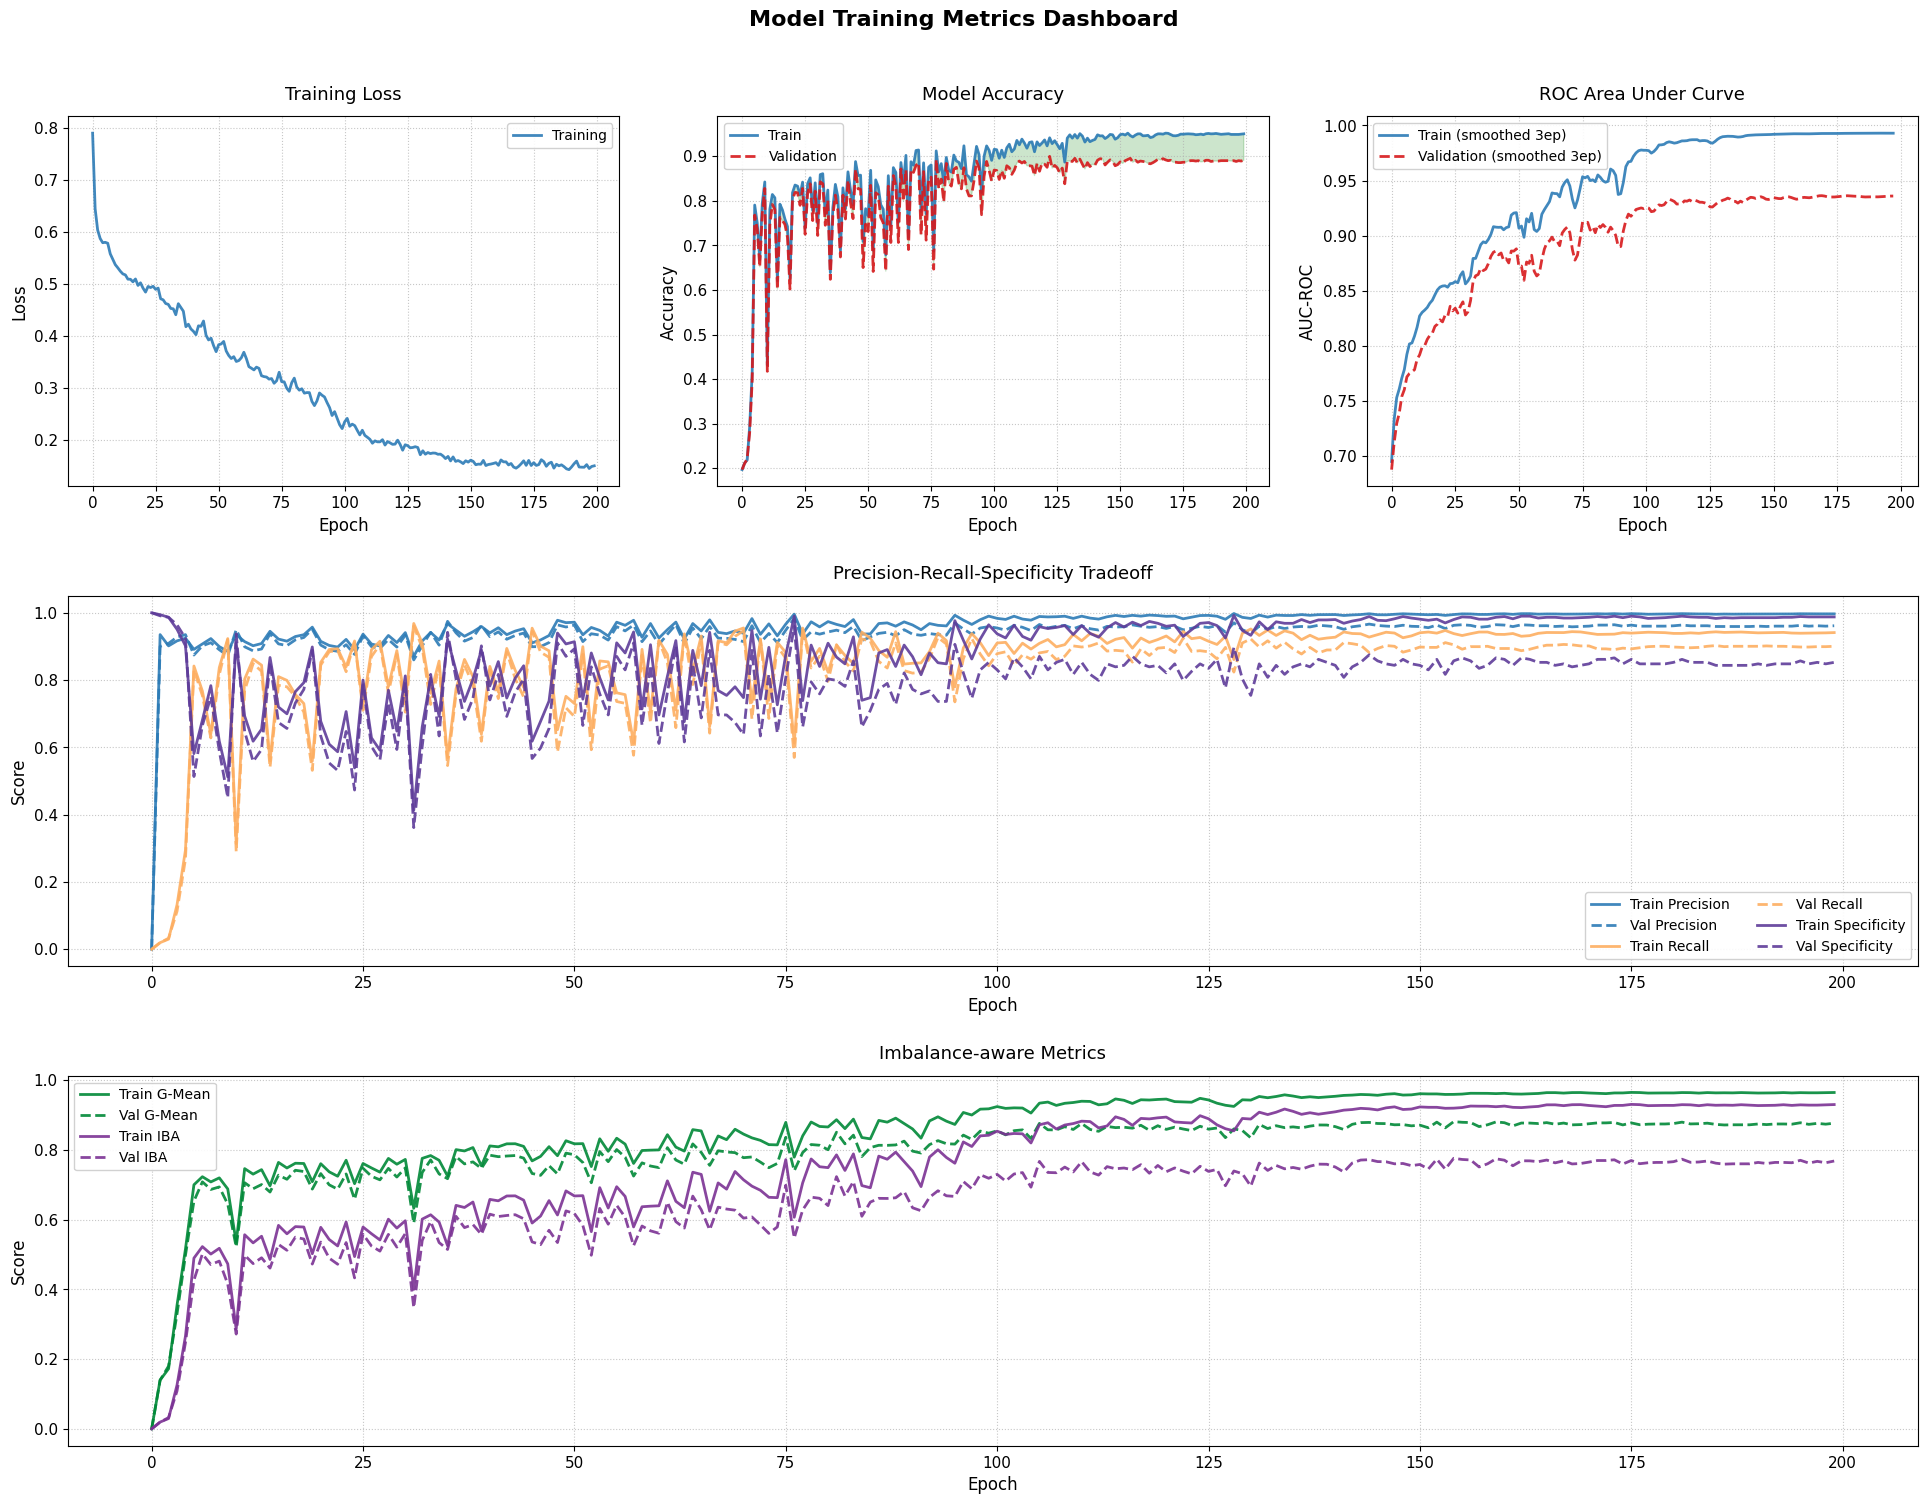

In [13]:
device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

train_loader, val_loader = load_data(
    batch_size=args.batch_size,
    num_workers=args.num_workers,
)

model = GNN(num_layer=args.num_layer, emb_dim=args.emb_dim, JK=args.JK, drop_ratio=args.dropout_ratio, gnn_type=args.gnn_type, output_dim=2)
trainer = Trainer(model, train_loader, val_loader)

trainer.run()

train_metrics=trainer.train_metrics
val_metrics=trainer.val_metrics
train_df = pd.DataFrame(train_metrics)
train_df.to_csv("train_metrics.csv", index=False)
val_df = pd.DataFrame(val_metrics)
val_df.to_csv("val_metrics.csv", index=False)

plot_training_dashboard(trainer)
